## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Schrödinger com os kets, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10. Para melhor coerência dos resultados, a otimização será utilizada para substituir na variável independente da função objetivo e ainda será normalizada para que as comparações tenham o mesmo peso.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

Para uma aproximação ótima, utiliza-se um passo de integração (fator do Runge Kutta) com o valor de 0.01, prevendo um milésimo a frente, mas para uma aplicação real a intenção é o aumento dessa fator para uma produção mais real.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01 # Passo de Integração

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo4[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[-1*complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

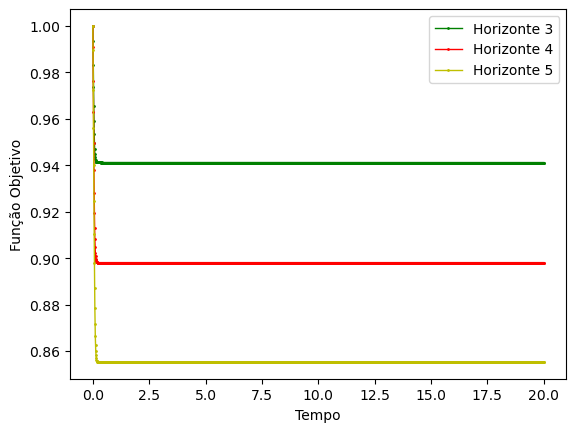

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0])/abs(valoresFuncaoObjetivo4[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0])/abs(valoresFuncaoObjetivo5[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.show()

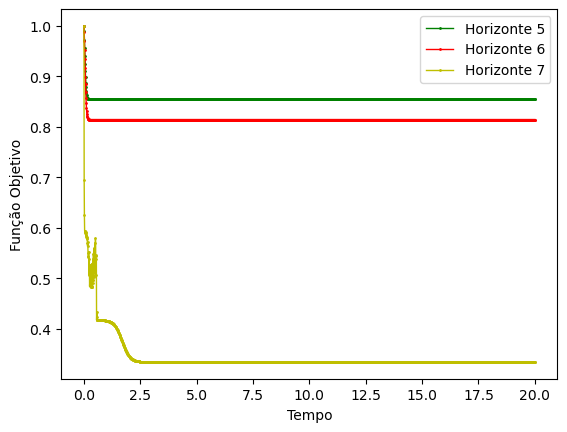

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0])/abs(valoresFuncaoObjetivo5[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0])/abs(valoresFuncaoObjetivo6[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0])/abs(valoresFuncaoObjetivo7[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.show()

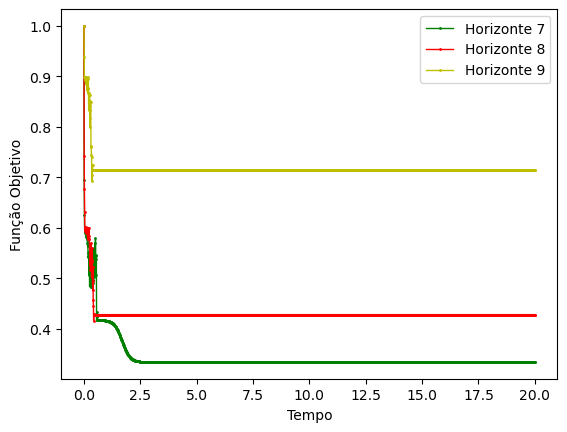

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0])/abs(valoresFuncaoObjetivo7[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0])/abs(valoresFuncaoObjetivo8[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0])/abs(valoresFuncaoObjetivo9[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.show()

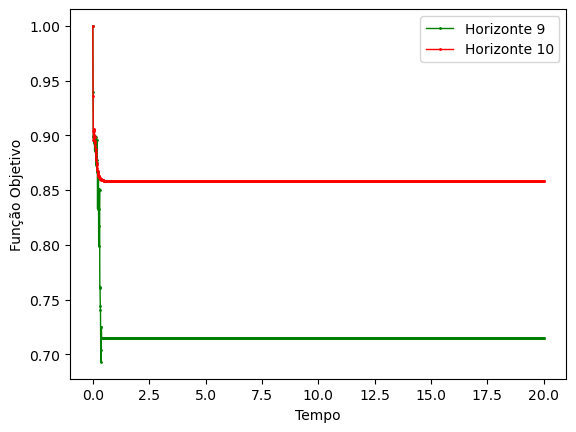

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0])/abs(valoresFuncaoObjetivo9[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0])/abs(valoresFuncaoObjetivo10[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem de uma curva em relação a outra.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na primeira componente quanto na segunda, além de realizar a diferença entre essas partes.

Tempo em centissegundos da parte real da origem [488, 887, 1288, 1300, 1687]
Tempo em centissegundos da parte real do destino [400, 800, 1200, 1600]
As defasagens da primeira componente é: [1.3823, 1.3666, 1.3823, -4.7124] em radianos.
A média das defasagens da primeira componente é: -0.14529999999999998 em radianos.


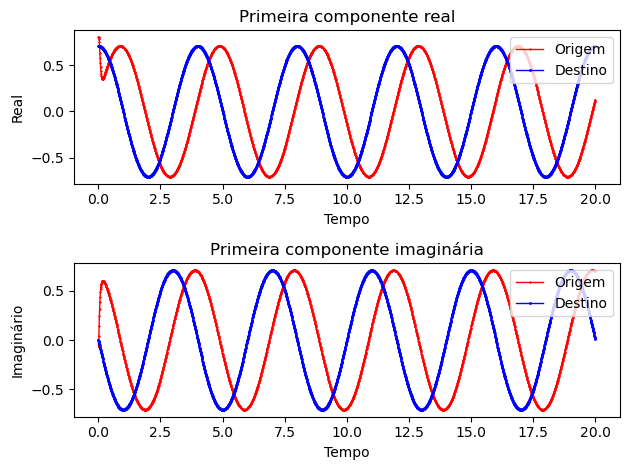

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (-1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()


### Avaliação do erro

diferencaAbsoluta3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))


### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(250, 1900, 350):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+350):
        maiorOrigem.append(realObjetivoPrimeiraComponente[j])
        maiorDestino.append(realDestinoPrimeiraComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 250
j = 0
while i < 1900 and j < len(maximosOrigem):
    if (realObjetivoPrimeiraComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(f"Tempo em centissegundos da parte real da origem {tempoOrigem}")

tempoDestino = []
i = 250
j = 0
while i < 1900 and j < len(maximosDestino):
    if (realDestinoPrimeiraComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(f"Tempo em centissegundos da parte real do destino {tempoDestino}")

defasagem3 = []
soma = 0
media = 0
for i in range(0, len(tempoDestino)):
    defasagem3.append(round((tempoOrigem[i] - tempoDestino[i])/400*2*np.pi,4))
    soma += defasagem3[i]

media = soma/len(tempoDestino)
print(f"As defasagens da primeira componente é: {defasagem3} em radianos.")
print(f"A média das defasagens da primeira componente é: {media} em radianos.")

[171, 304, 438, 571, 704, 838, 971, 1104, 1238, 1371, 1375, 1504, 1638, 1771]
[200, 333, 467, 600, 733, 867, 999, 1000, 1133, 1267, 1400, 1533, 1667, 1800]
A defasagem da primeira componente é: [-1.37, -1.37, -1.37, -1.37, -1.37, -1.37, -1.3228, 4.9132, 4.9604, 4.9132, -1.181, -1.37, -1.37, -1.37] em radianos.
A média das defasagens da segunda componente é: -0.0033571428571428997 em radianos.


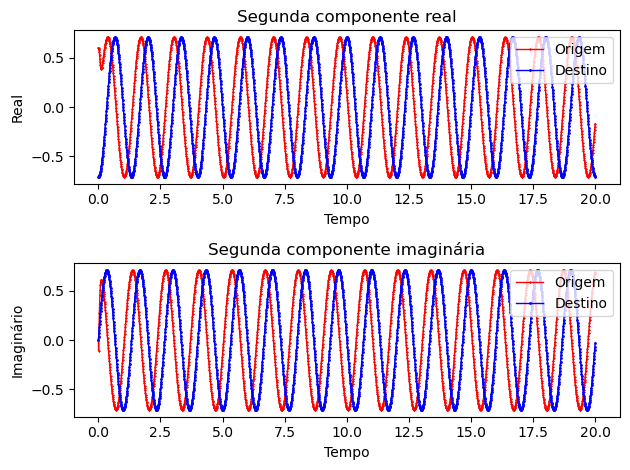

In [16]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Segunda componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Segunda componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(125, 2000, 125):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+125):
        maiorOrigem.append(realObjetivoSegundaComponente[j])
        maiorDestino.append(realDestinoSegundaComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 100
j = 0
while i < 1900 and j < len(maximosOrigem):
    if (realObjetivoSegundaComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 100
j = 0
while i < 1900 and j < len(maximosDestino):
    if (realDestinoSegundaComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem3 = []
soma = 0
media = 0
for i in range(0, len(tempoDestino)):
    defasagem3.append(round((tempoOrigem[i] - tempoDestino[i])/133*2*np.pi,4))
    soma += defasagem3[i]
    
media = soma/len(tempoDestino)
print(f"A defasagem da primeira componente é: {defasagem3} em radianos.")
print(f"A média das defasagens da segunda componente é: {media} em radianos.")

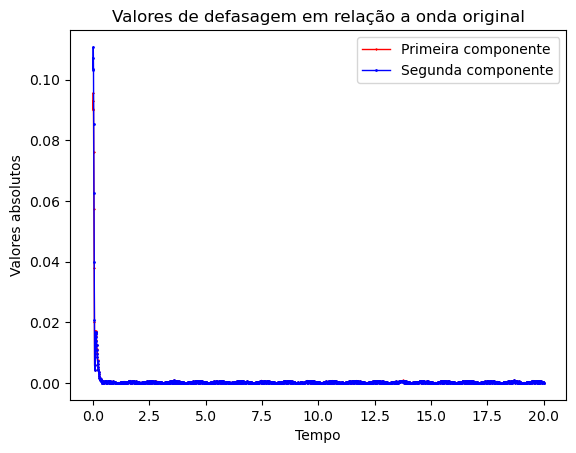

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [18]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta3[0],x) # Primeira componente

print(Integral)

Integral = trapz(diferencaAbsoluta3[1],x) # Segunda componente

print(Integral)

(0.003142029929980639+0j)
(-0.003856027588942706+0j)


Tempo em centissegundos da parte real da origem [479, 880, 1280, 1300, 1680]
Tempo em centissegundos da parte real do destino [400, 800, 1200, 1600]
A defasagem da primeira componente é: [1.2409, 1.2566, 1.2566, -4.7124] em radianos.
A média das defasagens da primeira componente é: -0.2395750000000001 em radianos.


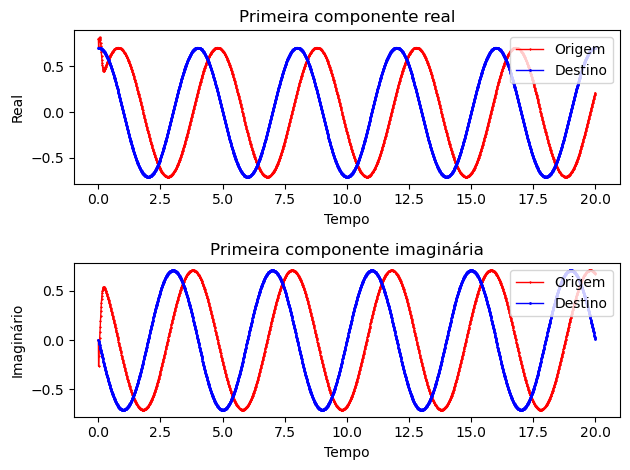

In [19]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda6[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda6[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda6[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda6[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (-1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação do erro

diferencaAbsoluta10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(250, 2000, 350):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+350):
        maiorOrigem.append(realObjetivoPrimeiraComponente[j])
        maiorDestino.append(realDestinoPrimeiraComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 300
j = 0
while i < 1900 and j < len(maximosOrigem):
    if (realObjetivoPrimeiraComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(f"Tempo em centissegundos da parte real da origem {tempoOrigem}")

tempoDestino = []
i = 300
j = 0
while i < 1900 and j < len(maximosDestino):
    if (realDestinoPrimeiraComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(f"Tempo em centissegundos da parte real do destino {tempoDestino}")

defasagem10 = []
soma = 0
media = 0
for i in range(0, len(tempoDestino)):
    defasagem10.append(round((tempoOrigem[i] - tempoDestino[i])/400 * 2 * np.pi, 4))
    soma += defasagem10[i]
    
media = soma/len(tempoDestino)
print(f"A defasagem da primeira componente é: {defasagem10} em radianos.")
print(f"A média das defasagens da primeira componente é: {media} em radianos.")

[173, 307, 440, 573, 707, 840, 973, 1107, 1240, 1373, 1375, 1507, 1640, 1773]
[200, 333, 467, 600, 733, 867, 999, 1000, 1133, 1267, 1400, 1533, 1667, 1800]
A defasagem da primeira componente é: [-1.2755, -1.2283, -1.2755, -1.2755, -1.2283, -1.2755, -1.2283, 5.0549, 5.0549, 5.0077, -1.181, -1.2283, -1.2755, -1.2755] em radianos.
A média das defasagens da segunda componente é: 0.09787857142857145 em radianos.


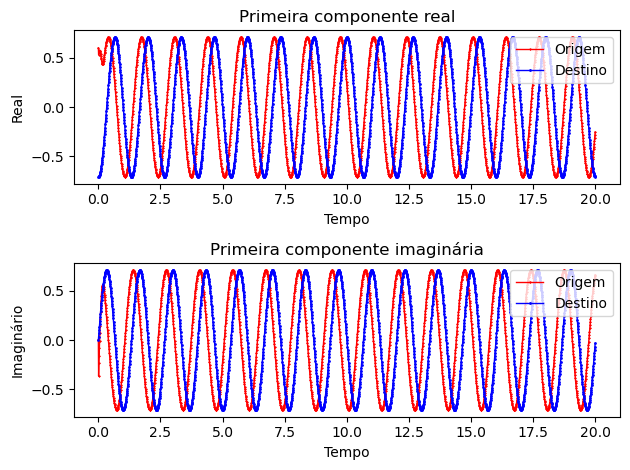

In [20]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(125, 2000, 125):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+125):
        maiorOrigem.append(realObjetivoSegundaComponente[j])
        maiorDestino.append(realDestinoSegundaComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 100
j = 0
while i < 1900 and j < len(maximosOrigem):
    if (realObjetivoSegundaComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 100
j = 0
while i < 1900 and j < len(maximosDestino):
    if (realDestinoSegundaComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem10 = []
soma = 0
media = 0
for i in range(0, len(tempoDestino)):
    defasagem10.append(round((tempoOrigem[i] - tempoDestino[i])/133*2*np.pi,4))
    soma += defasagem10[i]
    
media = soma/len(tempoDestino)
print(f"A defasagem da primeira componente é: {defasagem10} em radianos.")
print(f"A média das defasagens da segunda componente é: {media} em radianos.")

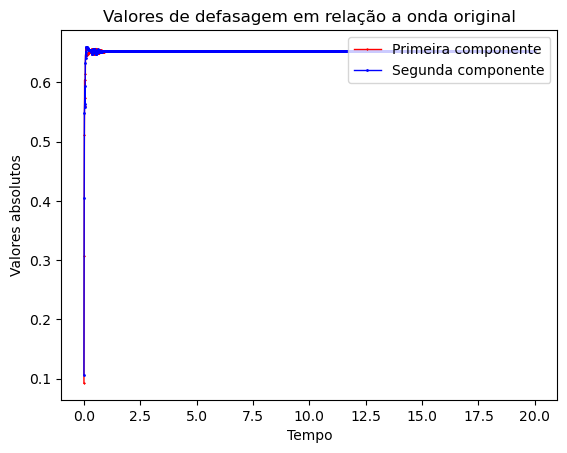

In [21]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [22]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta10[0],x)

print(Integral)

Integral = trapz(diferencaAbsoluta10[1],x)

print(Integral)

(-13.03848363262314+0j)
(-13.042023770120846+0j)


### Avaliação do mínimo

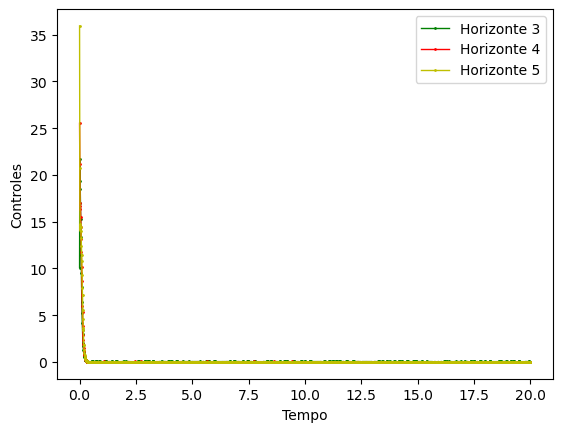

In [23]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Controles') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(minimos3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(minimos4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(minimos5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.show()

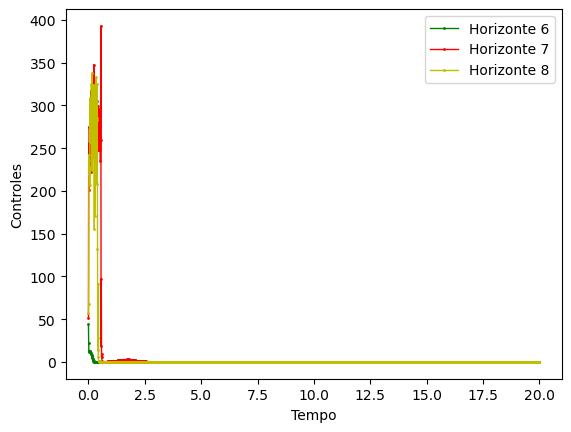

In [24]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Controles') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(minimos6[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(minimos7[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(minimos8[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.legend(loc="upper right")
plt.show()

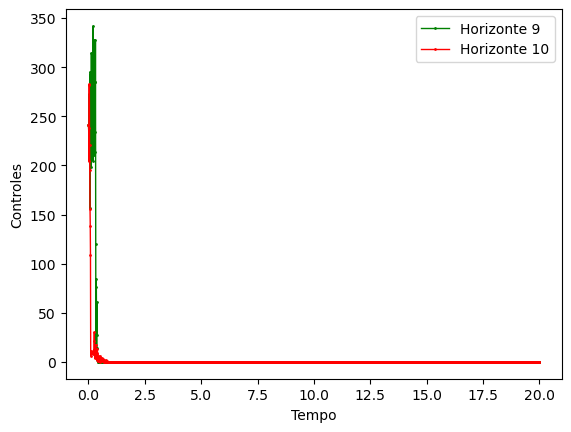

In [25]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Controles') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(minimos9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(minimos10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.show()

In [26]:
print(minimos8[0][1999])
print(minimos9[0][1999])
print(minimos10[0][1999])

(-0.005839470924575518+0j)
(-0.006837167508349902+0j)
(0.010293094241037505+0j)


### Outra forma de abordar a defasagem

In [27]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda10[0][i]/evolucaoDestino[0][i]))

(1.1313708498984762, 0.0)
(0.5649898023492121, -3.136605570887982)
(0.2772730340431173, 0.09747322599856971)
(0.1457701047578206, -1.9854854949628826)
(0.20656034374684987, -0.10069737416419682)
(0.18880509031875958, 1.942982104131558)
(0.1301161592244892, -0.5629384407682411)
(0.08508175012591974, -2.758431356485418)
(0.08476051885366775, 2.2351661430297205)
(0.07005076032545542, 0.6109991813485893)
(0.08653514661969598, -0.3866100651621118)
(0.08636510499502886, -0.338246762617649)
(0.086063435802014, -0.2671194965859679)
(0.0856316034771973, -0.18997254897662796)
(0.08502090830932986, -0.10335334388819249)
(0.08442141802602289, -0.02889642917857968)
(0.08378488050060433, 0.04667506633993452)
(0.08304876035771826, 0.13204092246663227)
(0.08228578266621958, 0.22050060229918872)
(0.08169961802648955, 0.29306451157548535)
(0.08107963755804402, 0.37916554693110166)
(0.0805293877421192, 0.46757312368158294)
(0.0800242668906995, 0.5665562492168973)
(0.0796733047103043, 0.6588626742129668)


In [28]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda10[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, -3.141592653589793)
(0.4261459571652709, 0.12369172167904861)
(0.2244583199812838, -2.757845552863937)
(0.2025947102557906, 1.3404801248482832)
(0.1609950481423482, -2.9887341953123014)
(0.20946298138354527, -1.2625687221745905)
(0.1042071920711892, 2.644604486214028)
(0.09209096853032699, 0.8645249521649454)
(0.07834271247976295, -0.9151703981127216)
(0.08540442011964323, -2.039856451808369)
(0.06657838017381104, 3.108983623694309)
(0.06679880946528416, -3.0929264192265444)
(0.06718703233795352, -2.9750715948855375)
(0.06773655411569511, -2.850074040276912)
(0.06850151373907952, -2.714074682343526)
(0.06923898036430036, -2.6013753797155803)
(0.07000789964207021, -2.491089799432719)
(0.07087958515241981, -2.3713734744624473)
(0.07176393336433196, -2.252535508257855)
(0.07243054997932205, -2.15871203995241)
(0.07312389837256138, -2.051061245252058)
(0.07372943667316974, -1.9440395877548058)
(0.07427737739812632, -1.827621684436747)
(0.07465371110192966, -1.7215488905

In [29]:
for i in range(0,2000):
    print(cmath.polar(valoresOnda3[0][i]/evolucaoDestino[0][i]))

(1.1313708498984762, 0.0)
(1.127513647180124, -0.07580599369207233)
(1.135234898935348, 0.08602705462377454)
(1.1271877519064597, 0.23077370713936327)
(1.1075334733351556, 0.37294303947690693)
(1.0812299369363194, 0.5101291805251633)
(1.0535107722294204, 0.6403000354723142)
(1.028555782729551, 0.7603132884344914)
(1.008359827558186, 0.8690026741670278)
(0.9939396738742594, 0.962363829724025)
(0.9842937942775635, 1.0433056640855762)
(0.9787681093858963, 1.1099691288369384)
(0.9762128263315891, 1.164309921346946)
(0.9756913772036869, 1.2076743172334368)
(0.9764882125711325, 1.2436167446229462)
(0.9782397352055919, 1.274965511862197)
(0.9801486626304134, 1.2963973150999355)
(0.9822410243228237, 1.313563128878582)
(0.9842363176808574, 1.3264623476104955)
(0.9861700444442633, 1.336769992528061)
(0.9879262844452742, 1.3447239231166022)
(0.9895414722402637, 1.3510730867784038)
(0.9909760395628048, 1.3560457939721255)
(0.9925630831178462, 1.3609555350868696)
(0.9933310484369253, 1.363096926257

(1.0002507298459717, 1.3751581666917299)
(1.0003244439056742, 1.375218981725629)
(1.0004000267333955, 1.3752774432765005)
(1.0004774033203074, 1.375333494155456)
(1.000556496895079, 1.3753870796044294)
(1.0006372290012573, 1.3754381473490707)
(1.0007195195762655, 1.3754866476490613)
(1.00080328703195, 1.3755325333456767)
(1.0003432302527124, 1.3752989539391005)
(0.9998758423478634, 1.37507972909616)
(0.9994015751127355, 1.3748750992045295)
(0.9989208876357634, 1.374685291475978)
(0.9991826946553403, 1.3747792822340137)
(0.9994472525565591, 1.3748649501059897)
(0.9997142980914692, 1.3749422189326588)
(0.9999835657491833, 1.3750110210898219)
(1.0002547880252177, 1.3750712975298631)
(1.000527695691991, 1.3751229978140718)
(1.0008020180701878, 1.3751660801356986)
(1.0005062807249265, 1.3751291054675887)
(1.0002094390574512, 1.37510141591412)
(0.999911785267481, 1.3750830497987796)
(0.9996136126151985, 1.3750740363412846)
(0.9993152151344609, 1.3750743955962437)
(0.9990168873442224, 1.37508

In [30]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda3[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, -3.141592653589793)
(0.8536467803567457, 3.007672053359472)
(0.8433506765440146, -2.985676542143584)
(0.8540760255846728, -2.7270966177317653)
(0.8794130369836336, -2.489845682648657)
(0.9115587113398189, -2.284495102570991)
(0.9434576891772986, -2.11200054116112)
(0.9706030716134256, -1.9700528882191723)
(0.9915683366083294, -1.8530297242269256)
(1.0060224794956827, -1.7593208864146799)
(1.015461978516418, -1.6818781053788765)
(1.0207890530194499, -1.6199690619735692)
(1.0232330233618072, -1.5702906624960808)
(1.023730256769817, -1.530879585653589)
(1.0229702208352354, -1.4981932611063857)
(1.0212954138364405, -1.4695402767912429)
(1.019463535829995, -1.4498081677423584)
(1.0174477243436297, -1.43387833167819)
(1.0155176869392102, -1.4218107105239841)
(1.0136399483351484, -1.4120923840140225)
(1.0119283363014653, -1.4045382043471273)
(1.0103489376979933, -1.3984677150210083)
(1.008941916108884, -1.3936844056840192)
(1.0073806762980901, -1.388933287281351)
(1.006623

### Avaliação das constantes



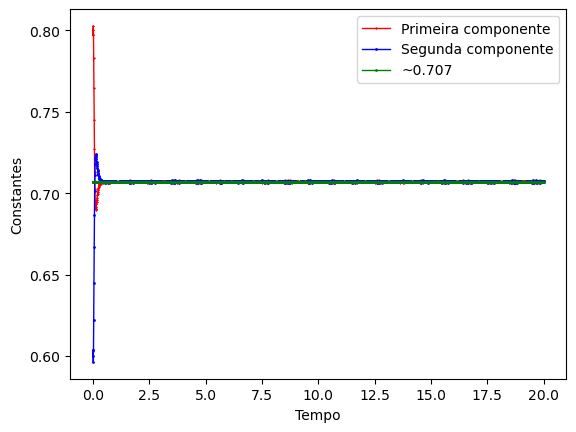

In [31]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

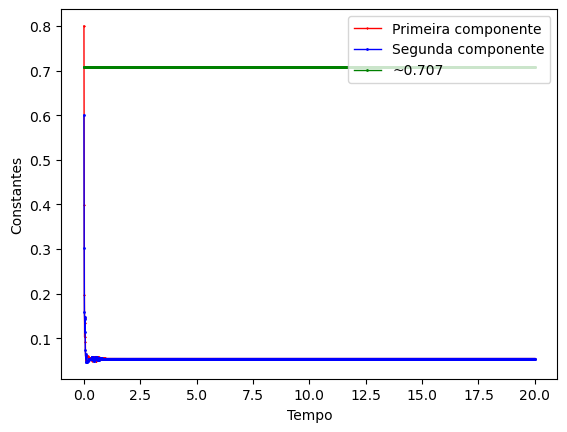

In [32]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

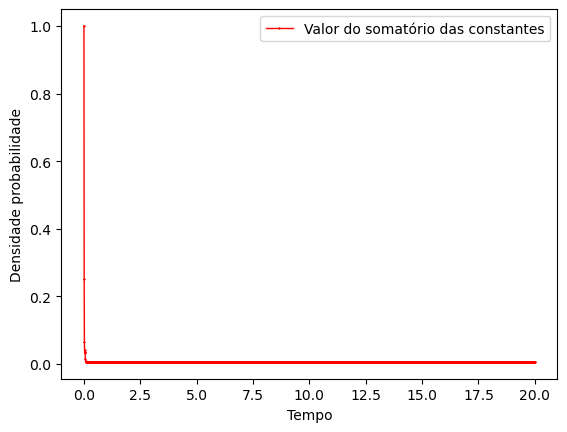

In [33]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
#plt.savefig('dp.png', format='png')
plt.show()